# gradient boosting oob estimates
- 그래디언트 부스팅 모델의 속성의 oob_improvement_ 값으로 oob 추정값을 확인 할 수 있다.
- oob_improvement_ 값은 부스팅의 최적의 수를 추정하는데 도움이 된다.

### 결과 그래프가 예시와 다르게 나옴

### create data samples

In [141]:
n_samples = 1000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)

x1.shape, x2.shape, x3.shape

((1000,), (1000,), (1000,))

In [142]:
%matplotlib inline

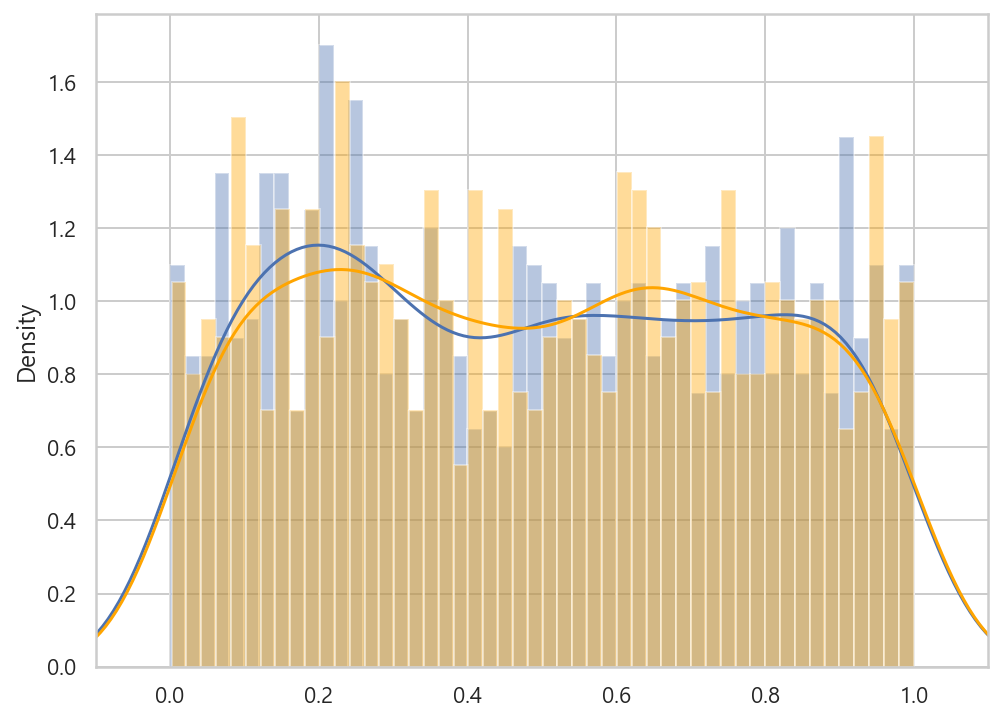

In [143]:
plt.figure(figsize=(8, 6))
sns.distplot(x1, bins=50, color="b")
sns.distplot(x2, bins=50, color="orange")
plt.xlim(-0.1, 1.1)
plt.show() ; 

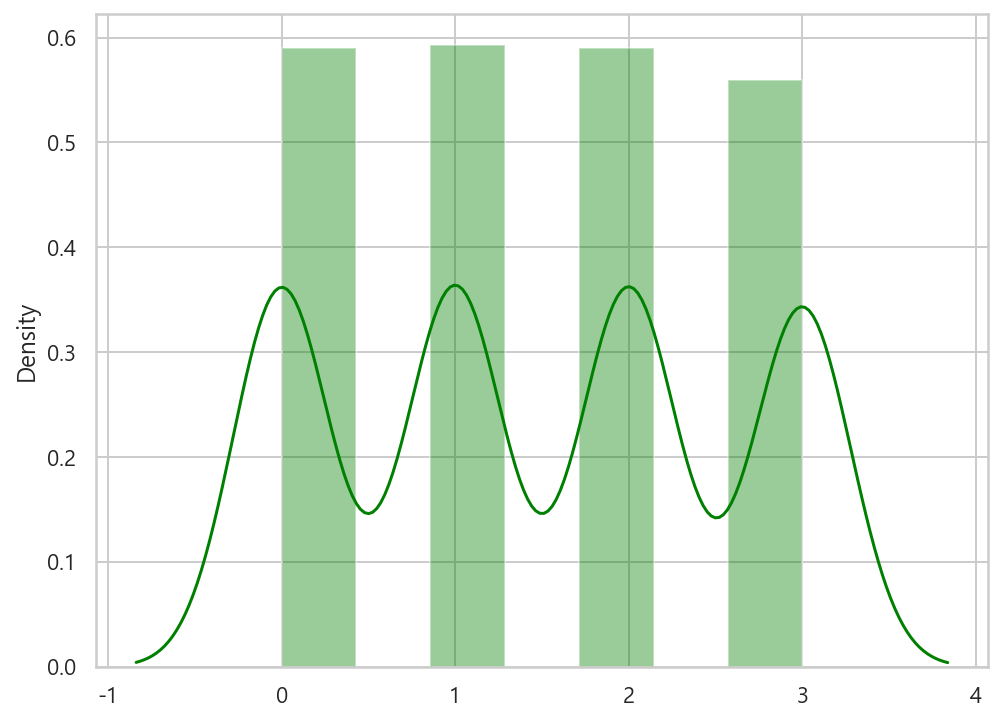

In [144]:
plt.figure(figsize=(8, 6))
sns.distplot(x3, bins=7, color="green")
plt.show() ; 

In [145]:
np.unique(x3, return_counts=True)

(array([0, 1, 2, 3]), array([253, 254, 253, 240], dtype=int64))

In [146]:
from scipy.special import expit

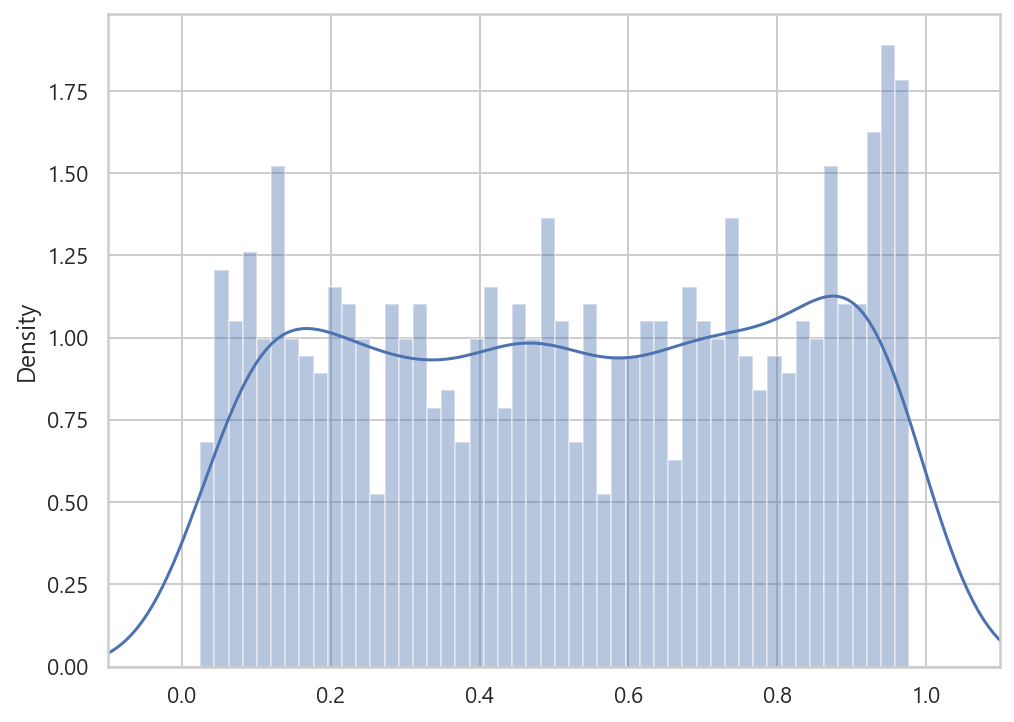

In [147]:
p = expit(np.sin(3 * x1) - 4 * x2 + x3)

plt.figure(figsize=(8, 6))
sns.distplot(p, bins=50)
plt.xlim(-0.1, 1.1)
plt.show() ; 

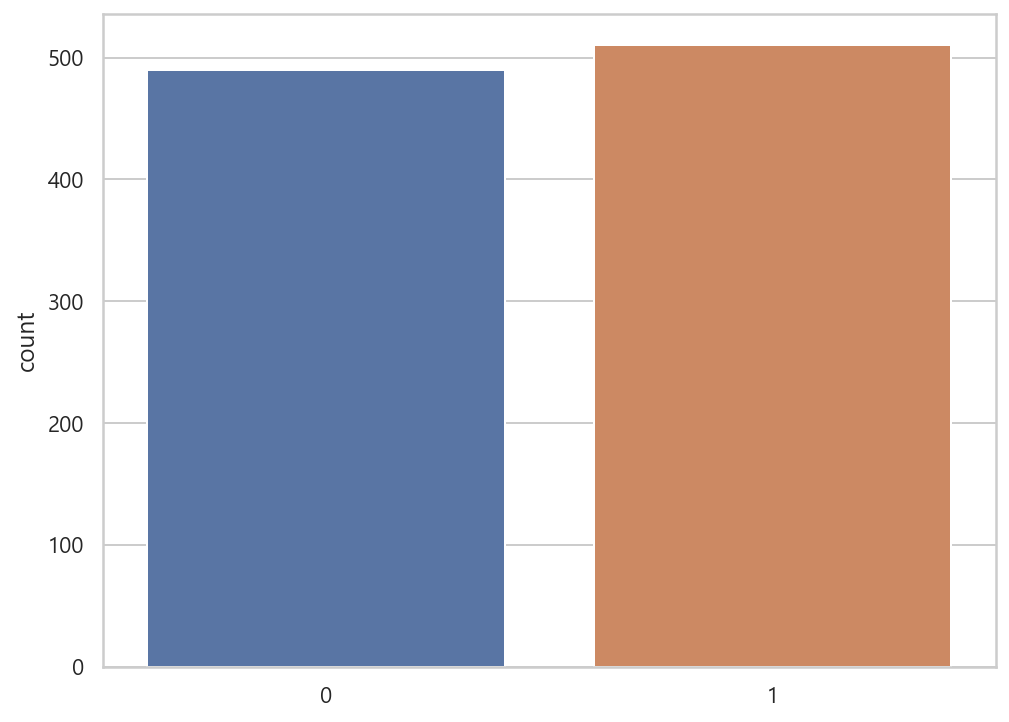

In [148]:
y = random_state.binomial(1, p, size=n_samples)

plt.figure(figsize=(8, 6))
sns.countplot(y)
plt.show() ; 

In [149]:
X = np.c_[x1, x2, x3]
X = X.astype(np.float32)
X[:5]

array([[7.7770239e-01, 9.1550684e-01, 3.0000000e+00],
       [2.3754121e-01, 7.2163361e-01, 1.0000000e+00],
       [8.2427853e-01, 4.1754031e-01, 0.0000000e+00],
       [9.6574920e-01, 8.3612388e-01, 1.0000000e+00],
       [9.7260112e-01, 2.5917678e-03, 2.0000000e+00]], dtype=float32)

### train test split

In [150]:
from sklearn.model_selection import train_test_split

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                   random_state=9)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((500, 3), (500, 3), (500,), (500,))

### GB model

In [152]:
params = {
    "n_estimators": 1200,
    "max_depth": 3,
    "subsample": 0.5,
    "learning_rate": 0.01,
    "min_samples_leaf": 1,
    "random_state": 3
}

params

{'n_estimators': 1200,
 'max_depth': 3,
 'subsample': 0.5,
 'learning_rate': 0.01,
 'min_samples_leaf': 1,
 'random_state': 3}

In [153]:
from sklearn.ensemble import GradientBoostingClassifier

In [154]:
clf = GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)

print("GB clf acc : {:.4f}".format(acc))

GB clf acc : 0.6800


### clf estimate : cv, oob

In [155]:
n_estimators = params["n_estimators"]
x = np.arange(n_estimators) + 1
x[:5]

array([1, 2, 3, 4, 5])

In [156]:
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

In [157]:
def heldout_score(clf, X_test, y_test) : 
    
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_proba in enumerate(clf.staged_predict_proba(X_test)) :
        score[i] = 2 * log_loss(y_test, y_proba[:, 1])
        
    return score

In [161]:
def cv_estimate(n_splits=None) : 
    
    cv = KFold(n_splits=n_splits)
    cv_clf = GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators, ), dtype=np.float64)
    cum_sum = np.zeros((n_estimators,), dtype=np.float64)
    
    # oob estimate
    for train, test in cv.split(X_train, y_train) : 
        cv_clf.fit(X_train[train], y_train[train])
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_splits
    
    return val_scores

### cv test에 oob 방식으로 데이터를 구분함
- log_loss 값을 누적하여 저장함

In [162]:
cv_score = cv_estimate(3)
cv_score

array([1.38206107, 1.37672064, 1.37078415, ..., 1.25194457, 1.25229826,
       1.25236937])

In [163]:
cv_score.shape

(1200,)

In [164]:
cv_score -= cv_score[0]
cv_score

array([ 0.        , -0.00534044, -0.01127692, ..., -0.13011651,
       -0.12976282, -0.1296917 ])

### train test split으로 구분한 검증 데이터 사용한 log_loss 값

In [165]:
test_score = heldout_score(clf, X_test, y_test)
test_score

array([1.38176281, 1.37597256, 1.3712185 , ..., 1.21166988, 1.21148576,
       1.21130124])

In [166]:
test_score -= test_score[0]
test_score

array([ 0.        , -0.00579025, -0.01054431, ..., -0.17009292,
       -0.17027705, -0.17046157])

In [167]:
arr = np.array([1, 2, 3, 4])
arr -= arr[0]
arr

array([0, 1, 2, 3])

### clf의 oob_improvement 값
- 이 값을 누적 합산하여 저장함

In [168]:
clf.oob_improvement_

array([ 0.00511979,  0.00610205,  0.00524492, ..., -0.00023468,
       -0.00042467, -0.00084729])

In [169]:
cumsum = -np.cumsum(clf.oob_improvement_)
cumsum

array([-0.00511979, -0.01122184, -0.01646676, ...,  0.09964857,
        0.10007324,  0.10092053])

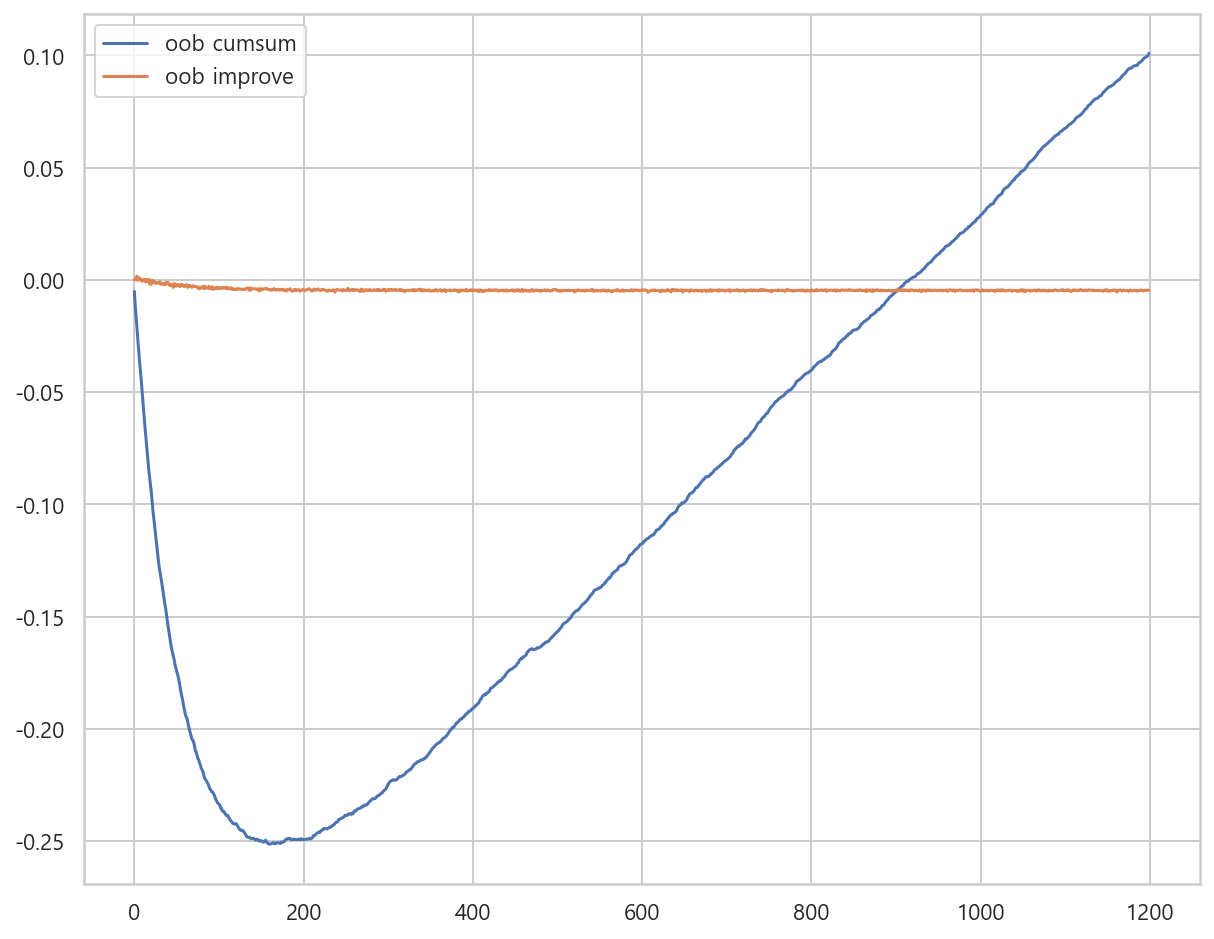

In [177]:
plt.figure(figsize=(10, 8))
plt.plot(range(n_estimators), cumsum, label="oob cumsum")
plt.plot(range(n_estimators), oob_improv, label="oob improve")
plt.legend()
plt.show() ; 

### cv, oob, test 별 가장 작은 값의 인덱스
- x는 1~1200

In [171]:
x

array([   1,    2,    3, ..., 1198, 1199, 1200])

In [172]:
oob_best_iter = x[np.argmin(cumsum)]
oob_best_iter

160

In [173]:
test_best_iter = x[np.argmin(test_score)]
test_best_iter

301

In [174]:
cv_best_iter = x[np.argmin(cv_score)]
cv_best_iter

253

### plot

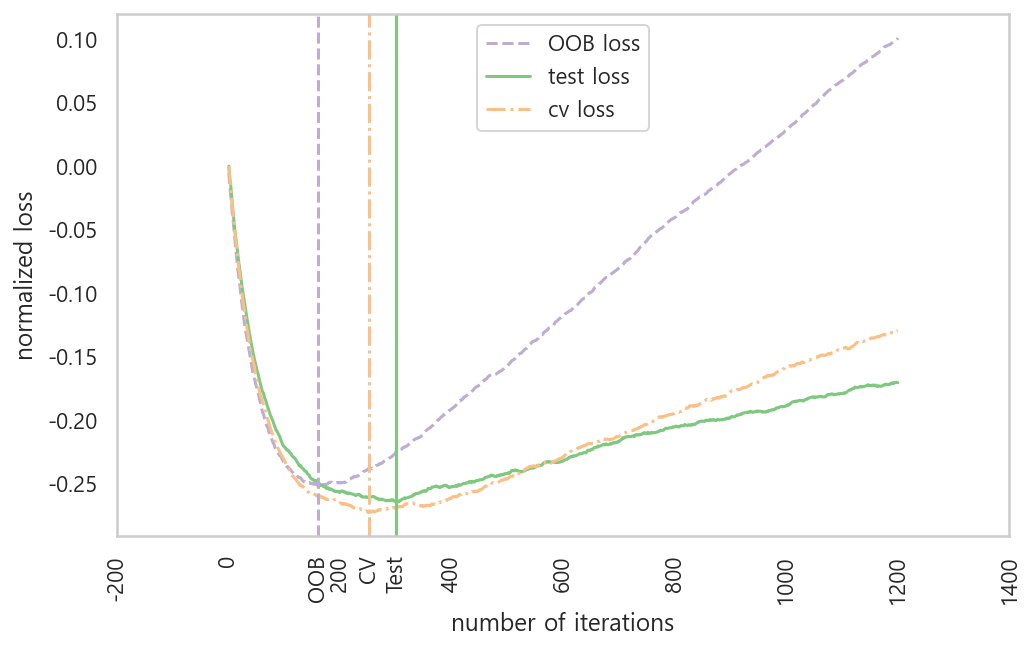

In [175]:
oob_color = list(map(lambda x : x/256.0, (190, 174, 212)))
test_color = list(map(lambda x : x/256.0, (127, 201, 127)))
cv_color = list(map(lambda x : x/256.0, (253, 192, 134)))

oob_line = "dashed"
test_line = "solid"
cv_line = "dashdot"

plt.figure(figsize=(8, 4.8))
plt.plot(x, cumsum, label="OOB loss", color=oob_color, linestyle=oob_line)
plt.plot(x, test_score, label="test loss", color=test_color, linestyle=test_line)
plt.plot(x, cv_score, label="cv loss", color=cv_color, linestyle=cv_line)

plt.axvline(x=oob_best_iter, color=oob_color, linestyle=oob_line)
plt.axvline(x=test_best_iter, color=test_color, linestyle=test_line)
plt.axvline(x=cv_best_iter, color=cv_color, linestyle=cv_line)

xticks = plt.xticks()
xticks_pos = np.array(xticks[0].tolist() + \
                      [oob_best_iter, cv_best_iter, test_best_iter])
xticks_label = np.array(list(map(lambda t : int(t), xticks[0])) + \
                       ["OOB", "CV", "Test"])
plt.xticks(xticks_pos, xticks_label, rotation=90)

plt.legend(loc="upper center")
plt.xlabel("number of iterations")
plt.ylabel("normalized loss")
plt.grid(False)
plt.show() ; 

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

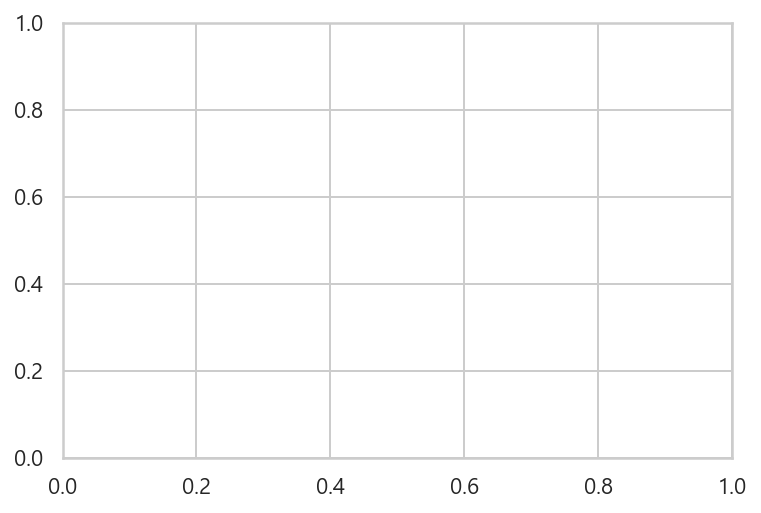

In [81]:
xticks = plt.xticks()
xticks[0]

In [83]:
xticks_pos = np.array(xticks[0].tolist() + \
                      [oob_best_iter, cv_best_iter, test_best_iter])
xticks_pos

array([0.00e+00, 2.00e-01, 4.00e-01, 6.00e-01, 8.00e-01, 1.00e+00,
       1.71e+02, 2.30e+02, 2.94e+02])

In [84]:
xticks_label = np.array(list(map(lambda t : int(t), xticks[0])) + \
                       ["OOB", "CV", "Test"])
xticks_label

array(['0', '0', '0', '0', '0', '1', 'OOB', 'CV', 'Test'], dtype='<U11')